In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [42]:
customer_data = pd.read_csv('./data/Customers.csv')
product_data = pd.read_csv('./data/Products.csv')
transaction_data = pd.read_csv('./data/Transactions.csv')

In [43]:
data = pd.merge(transaction_data, customer_data, on="CustomerID")

In [44]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00761,C0199,P022,2024-10-01 05:57:09,4,550.16,137.54,Andrea Jenkins,Europe,2022-12-03
2,T00626,C0199,P079,2024-08-17 12:06:08,2,834.74,417.37,Andrea Jenkins,Europe,2022-12-03
3,T00963,C0199,P008,2024-10-26 00:01:58,2,293.70,146.85,Andrea Jenkins,Europe,2022-12-03
4,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04


In [45]:
# Feature Engineering: Aggregate transaction data per customer
cus_data = data.groupby('CustomerID').agg(
    total_transactions=('TransactionID', 'count'),
    total_spent=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days),
    frequency=('TransactionDate', lambda x: (pd.to_datetime('today') - pd.to_datetime(x.min())).days)
).reset_index()

cus_data.head()

,CustomerID,total_transactions,total_spent,avg_transaction_value,recency,frequency
0,C0001,5,3354.52,670.904,85,374
1,C0002,4,1862.74,465.685,55,334
2,C0003,4,2725.38,681.345,155,344
3,C0004,8,5354.88,669.360,35,334
4,C0005,3,2034.24,678.080,84,318


In [46]:
# Merge with customer profile data
cus_data = pd.merge(cus_data, customer_data[['CustomerID', 'Region']], on='CustomerID', how='left')

In [47]:
# Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cus_data[['total_transactions', 'total_spent', 'avg_transaction_value', 'recency', 'frequency']])

In [48]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

print(inertia)

C:\Users\dines\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\dines\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dines\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\dines\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

[712.7926056303126, 589.3273395058271, 490.58026427417605, 400.10935363012976, 357.05774671503946, 325.2718913677038, 298.5828819222783, 280.98261396072957, 258.2723949420519]


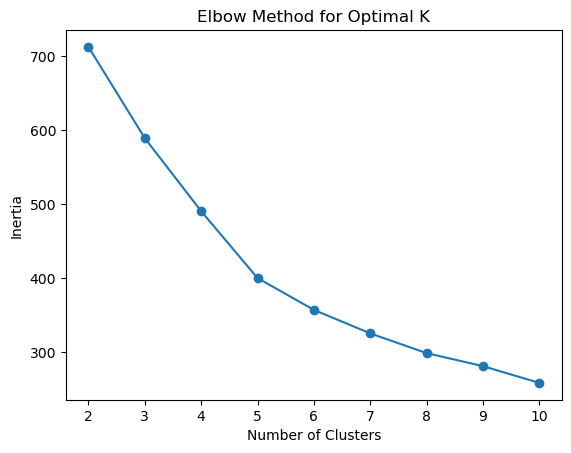

In [49]:
# Plot
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [50]:
# Based on the Elbow Method, let's assume K=4 is the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cus_data['Cluster'] = kmeans.fit_predict(scaled_data)

C:\Users\dines\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\dines\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [51]:
# Evaluate the clusters using the Silhouette Score and DB Index
sil_score = silhouette_score(scaled_data, cus_data['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.257099993060434


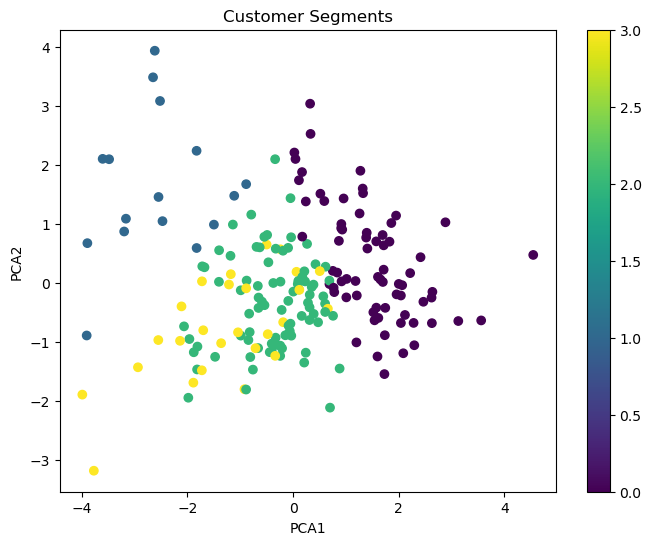

In [52]:
# Visualize the clusters using PCA (2D plot)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
cus_data['PCA1'] = pca_components[:, 0]
cus_data['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(cus_data['PCA1'], cus_data['PCA2'], c=cus_data['Cluster'], cmap='viridis', marker='o')
plt.title('Customer Segments')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar()
plt.show()

In [53]:
# Calculate DB Index
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(scaled_data, cus_data['Cluster'])
print(f"DB Index: {db_index}")

DB Index: 1.2072386116841094


In [54]:
# Show cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

Cluster Centers:
 [[ 0.78986212  1.07569487  0.65401036 -0.17677371  0.42570043]
 [-1.46507277 -1.27729936 -0.39691767  2.51343243 -0.04637794]
 [-0.14774479 -0.46732368 -0.46494355 -0.23520352  0.24434911]
 [-0.7305918  -0.54633428  0.03923254 -0.28377126 -1.93520596]]


In [55]:
# Optional: Explore the characteristics of each cluster
for cluster_num in range(4):
    print(f"\nCluster {cluster_num} Stats:")
    print(cus_data[cus_data['Cluster'] == cluster_num].describe())


Cluster 0 Stats:
       total_transactions   total_spent  avg_transaction_value     recency  \
count           70.000000     70.000000              70.000000   70.000000   
mean             6.757143   5433.757143             842.801735   91.571429   
std              1.891520   1212.750125             194.072887   50.440256   
min              3.000000   3424.320000             427.161000   30.000000   
25%              5.000000   4577.287500             717.725937   44.500000   
50%              7.000000   5305.725000             818.305893   84.500000   
75%              8.000000   6016.490000             961.002500  132.750000   
max             11.000000  10673.870000            1323.133333  262.000000   

        frequency  Cluster       PCA1       PCA2  
count   70.000000     70.0  70.000000  70.000000  
mean   357.128571      0.0   1.502459   0.352608  
std     37.589669      0.0   0.851426   0.970220  
min    186.000000      0.0   0.024155  -1.547518  
25%    345.000000      0

In [56]:
# Save the results as a CSV
cus_data.to_csv('Customer_Segmentation_Results.csv', index=False)